# CESM2-LE Micro predictability analysis
 - examines initialization signal in density-space overturning circulation
 - analysis should be performed on Casper

In [2]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [31]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [3]:
# ONLY RUN THIS CELL ONCE  
# NOTE: you may need to change the project number
from ncar_jobqueue import NCARCluster 
from dask.distributed import Client
proj = 'NCGD0011'

# Request cluster with predetermined number of cores:
#ncores = 36
#nmem   = str(int(375*ncores/36))+'GB'
#cluster = NCARCluster(cores=ncores,
#                     death_timout=60, 
#                     processes=ncores, memory=nmem,
#                     project=proj,
#                     walltime='1:00:00')
#cluster.scale(ncores)

# Request adaptive cluster that scales up/down on the fly:
cluster=NCARCluster(project=proj,memory='50GB')
cluster.adapt(minimum=8,maximum=18,wait_count=30) 

client = Client(cluster)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

### Data I/O functions:

In [5]:
def micro_nested_file_list_by_member(datadir,ens,microlabel):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        mmm = str(ee).zfill(3)
        casename = 'b.e21.BHISTcmip6.f09_g17.'+microlabel+'.'+mmm
        if (ee>10):  casename = 'b.e21.BHISTsmbb.f09_g17.'+microlabel+'.'+mmm
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [6]:
def macro1_nested_file_list_by_member(datadir,ens):
    members = []
    for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
        s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
        members.append(s)
    
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        casename = 'b.e21.BHISTcmip6.f09_g17.'+members[i]
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [7]:
def macro2_nested_file_list_by_member(datadir,ens):    
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        mmm = str(ee).zfill(3)
        casename = 'b.e21.BHIST.f09_g17.CMIP6-historical.'+mmm
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [8]:
def open_single_member(files):
    
    d0 = xr.open_mfdataset(files,combine='by_coords',parallel=True,concat_dim='time',chunks={},compat='override', coords='minimal')
    # quick fix to adjust time vector for monthly data  
    nmonths = len(d0.time)
    yr0 = d0['time.year'][0].values
    d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    
    return d0

In [9]:
def get_data(files):
    ''' returns dask array containing the requested hindcast ensemble '''

    ens = np.array(range(np.shape(files)[0]))+1
    dsets = []
    in_obj = [[ffs] for ffs in files]
    dsets = client.map(open_single_member, in_obj)
    dsets = client.gather(dsets)
    ds = xr.concat(dsets,dim='M',coords='minimal', compat='override')
    ds = ds.assign_coords(M=("M",ens))

    return ds

## Read in Micro and Macro Ensembles
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}
  - 20-member large macro ensemble (macro1 + macro2)

In [10]:
%%time
# Micro 1231
files1231,mems1231 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1231')
ds1231 = get_data(files1231)

CPU times: user 580 ms, sys: 50.2 ms, total: 630 ms
Wall time: 4.03 s


In [11]:
%%time
# Micro 1251
files1251,mems1251 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1251')
ds1251 = get_data(files1251)

CPU times: user 533 ms, sys: 45.7 ms, total: 579 ms
Wall time: 2.47 s


In [12]:
%%time
# Micro 1281
files1281,mems1281 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1281')
ds1281 = get_data(files1281)

CPU times: user 536 ms, sys: 29.4 ms, total: 566 ms
Wall time: 2.48 s


In [13]:
%%time
# Micro 1301
files1301,mems1301 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1301')
ds1301 = get_data(files1301)

CPU times: user 566 ms, sys: 46.1 ms, total: 612 ms
Wall time: 2.41 s


In [14]:
%%time
# Macro 1 (10 member from Korea)
filesm1,memsm1 = macro1_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(10))
dsmacro1 = get_data(filesm1)

CPU times: user 235 ms, sys: 20.4 ms, total: 255 ms
Wall time: 1.21 s


In [15]:
%%time
# Macro 2 (10 member from CMIP6)
filesm2,memsm2 = macro2_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(10))
dsmacro2 = get_data(filesm2)

CPU times: user 275 ms, sys: 20.5 ms, total: 296 ms
Wall time: 1.92 s


In [16]:
%%time
# Construct full 20-member macro ensemble
dsmacro2 = dsmacro2.assign_coords(M=("M",np.array(range(10))+11))
dsmacro = xr.concat([dsmacro1,dsmacro2],dim='M',coords='minimal', compat='override')

CPU times: user 5.05 ms, sys: 718 µs, total: 5.77 ms
Wall time: 5.63 ms


### Decadal Micro differences from Macro:

CPU times: user 17.5 s, sys: 1.01 s, total: 18.5 s
Wall time: 2min 19s


<timed exec>:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


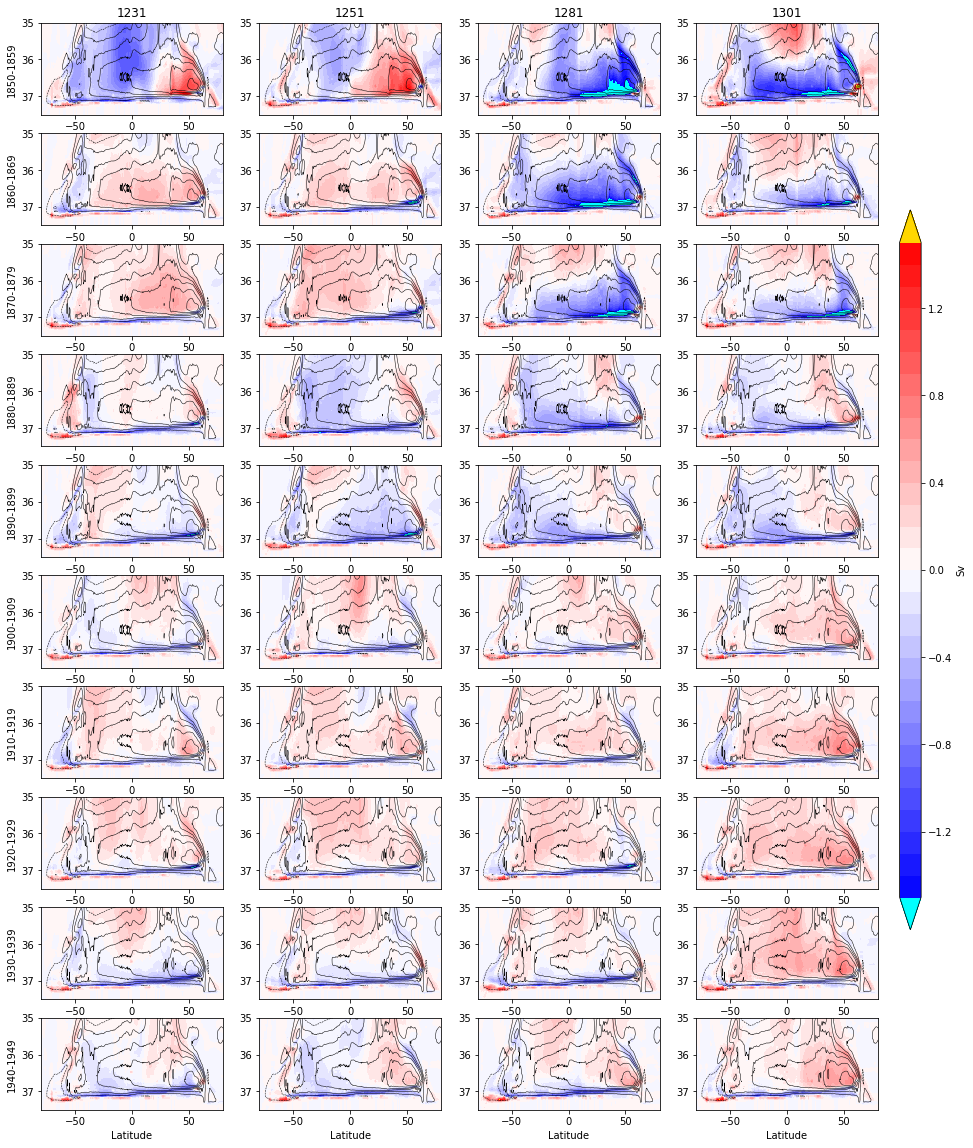

In [17]:
%%time
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-80, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-80, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-80, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-80, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 17.8 s, sys: 924 ms, total: 18.7 s
Wall time: 2min 22s


<timed exec>:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


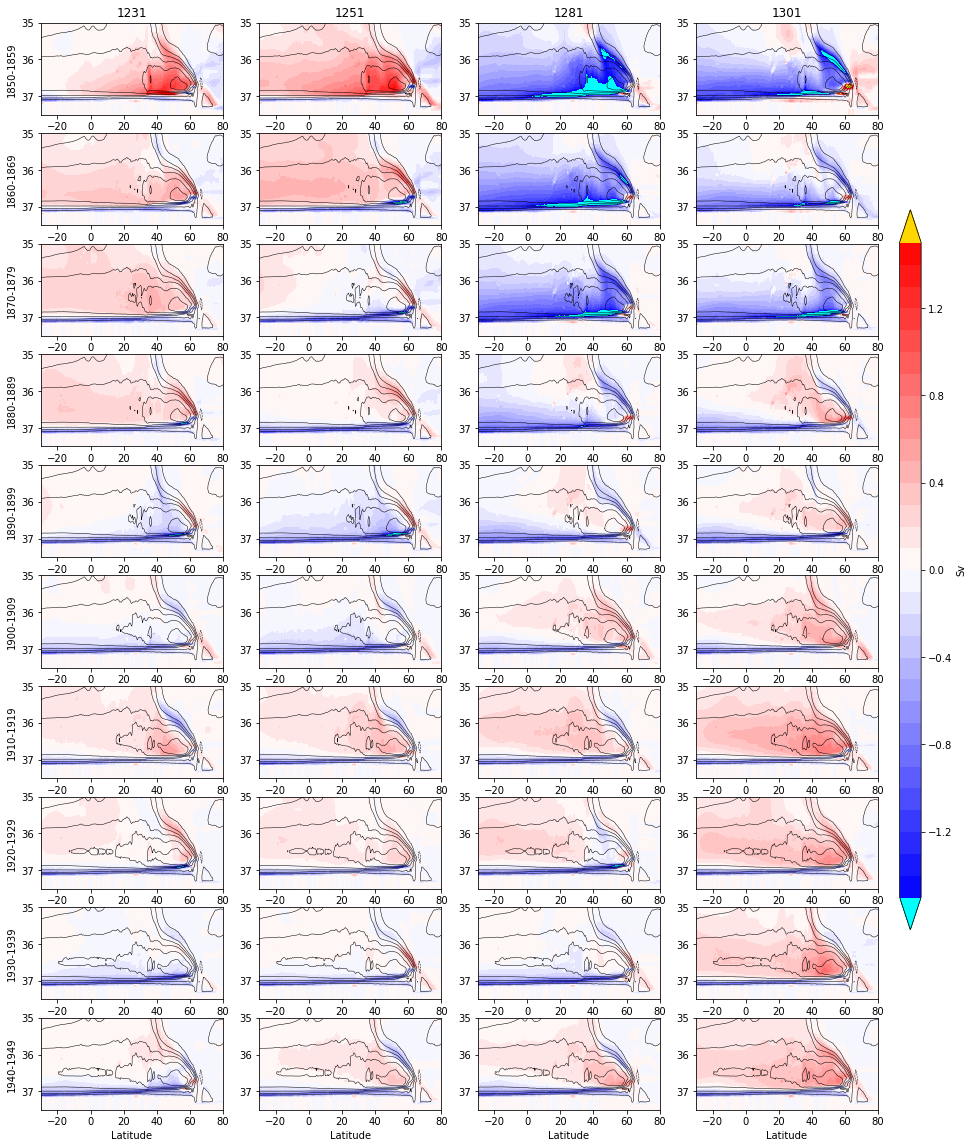

In [18]:
%%time
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-30, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-30, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-30, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-30, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

### Decadal Micro differences from Macro1:

CPU times: user 28 s, sys: 1.35 s, total: 29.3 s
Wall time: 1min 53s


<timed exec>:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


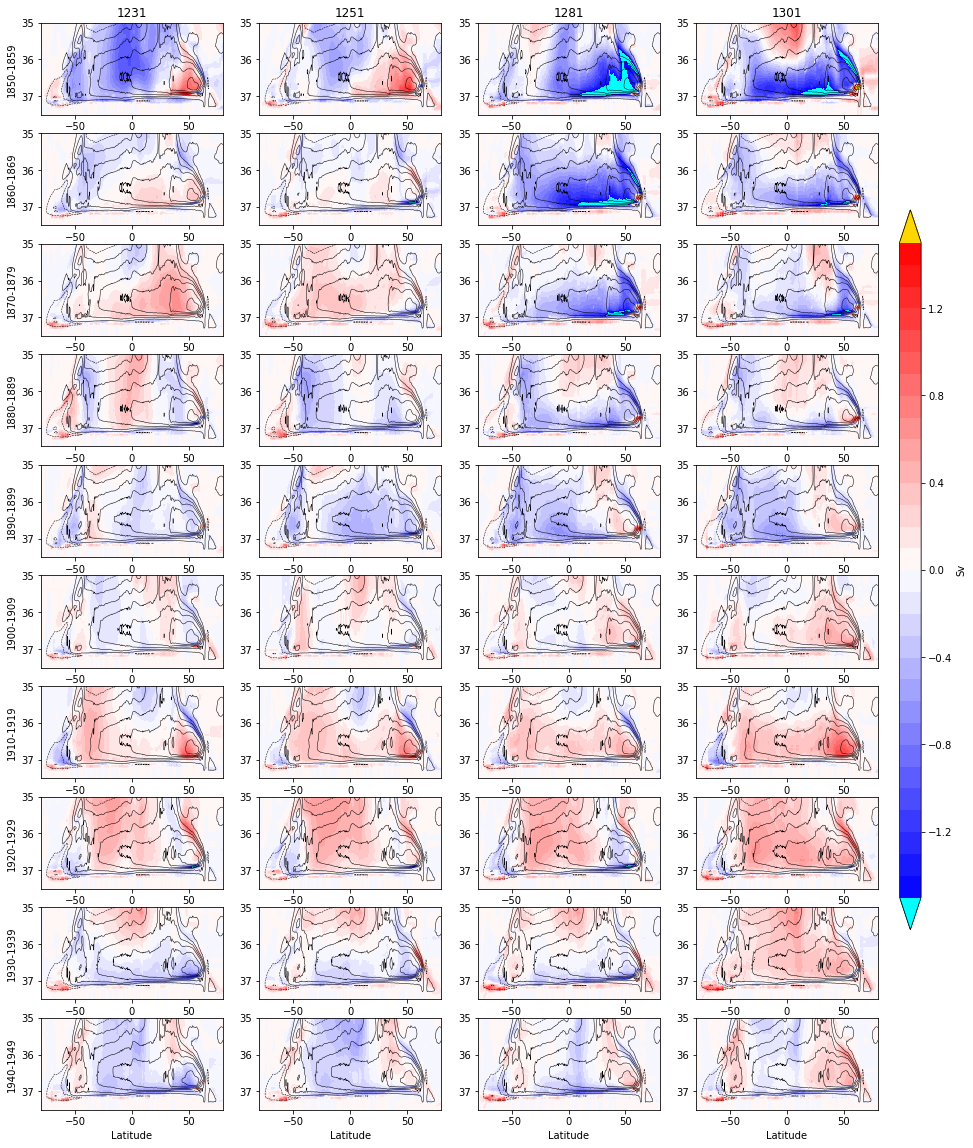

In [17]:
%%time
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro1.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-80, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-80, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-80, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-80, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 13.6 s, sys: 683 ms, total: 14.3 s
Wall time: 1min 49s


<timed exec>:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


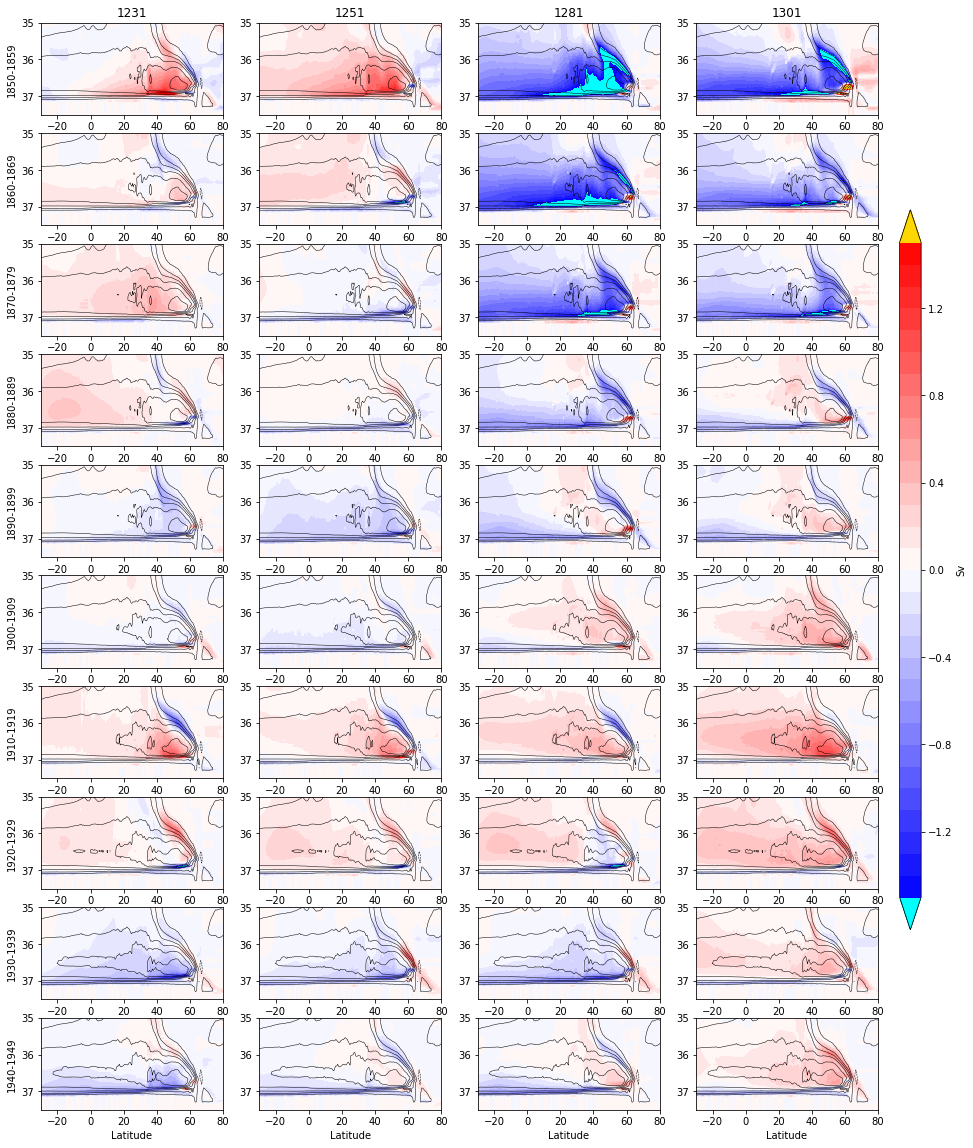

In [19]:
%%time
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro1.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-30, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-30, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-30, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-30, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

### Decadal Prognostic Potential Predictability:
  - Following Pohlmann et al. (2004, J. Clim, 17, 4463-4472), measures ratio of ensemble variance relative to temporal variance from CESM2 pre-industrial control simulation:<br>
  $PPP(t) = 1 - \frac{\sigma_{ens}^2(t)}{\sigma_{pic}^2}$

In [22]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,chunks={"moc_s":1},decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [23]:
# Get background std dev from PI control:
dspic = open_POPdataset('/glade/work/yeager/cesm_output/b.e21.B1850.f09_g17.CMIP6-piControl.001/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.MOCsig.nc')
dspic

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 3, moc_s: 87, time: 24000, transport_reg: 2)
Coordinates:
  * time               (time) object 0001-01-17 00:00:00 ... 2000-12-17 00:00:00
    transport_regions  (transport_reg) |S256 dask.array<chunksize=(2,), meta=np.ndarray>
  * moc_comp           (moc_comp) |S256 b'Eulerian Mean' ... b'Submeso'
  * moc_s              (moc_s) float64 27.9 28.1 28.3 28.5 ... 37.92 37.98 38.02
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg
Data variables:
    MOCsig             (time, transport_reg, moc_comp, moc_s, lat_aux_grid) float32 dask.array<chunksize=(24000, 2, 3, 1, 395), meta=np.ndarray>
Attributes:
    history:  Sat Mar 21 17:35:51 2020: ncrcat /glade/work/yeager/cesm_output...
    NCO:      netCDF Operators version 4.7.9 (Homepage = http://nco.sf.net, C...

In [24]:
%%time
pic_moc = dspic.MOCsig.sum('moc_comp')
pic_mocann = pic_moc.groupby('time.year').mean('time').load()
pic_mocann = pic_mocann.rename({'year':'time'})

### Compute std dev of detrended, low-pass filtered MOC from PI-control (years 1001-2000)

In [25]:
tmp = pic_mocann.sel(time=slice(1001,2000))
pic_mocann_anom = tmp - tmp.mean('time')

In [26]:
#pic_mocann_anom.isel(transport_reg=0).sel(moc_s=36.9,method='nearest').sel(lat_aux_grid=50.,method='nearest').plot();

In [27]:
# Annual Detrended Anomalies
pic_mocann_anom_dt = xr.apply_ufunc(signal.detrend, pic_mocann_anom.fillna(0), kwargs={'axis': 0}).where(pic_mocann_anom.notnull())

In [28]:
#pic_mocann_anom_dt.isel(transport_reg=0).sel(moc_s=36.9,method='nearest').sel(lat_aux_grid=50.,method='nearest').plot();

In [30]:
#pic_mocann_anom_dt.isel(transport_reg=0).sel(moc_s=36.9,method='nearest').sel(lat_aux_grid=50.,method='nearest').rolling(time=10,center=True).mean().plot();

In [31]:
pic_lpf_sd = pic_mocann_anom_dt.rolling(time=10,center=True).mean().std('time')
pic_lpf_sd = pic_lpf_sd.where(pic_lpf_sd > 0.01)

CPU times: user 15.5 s, sys: 883 ms, total: 16.4 s
Wall time: 1min 23s


<timed exec>:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


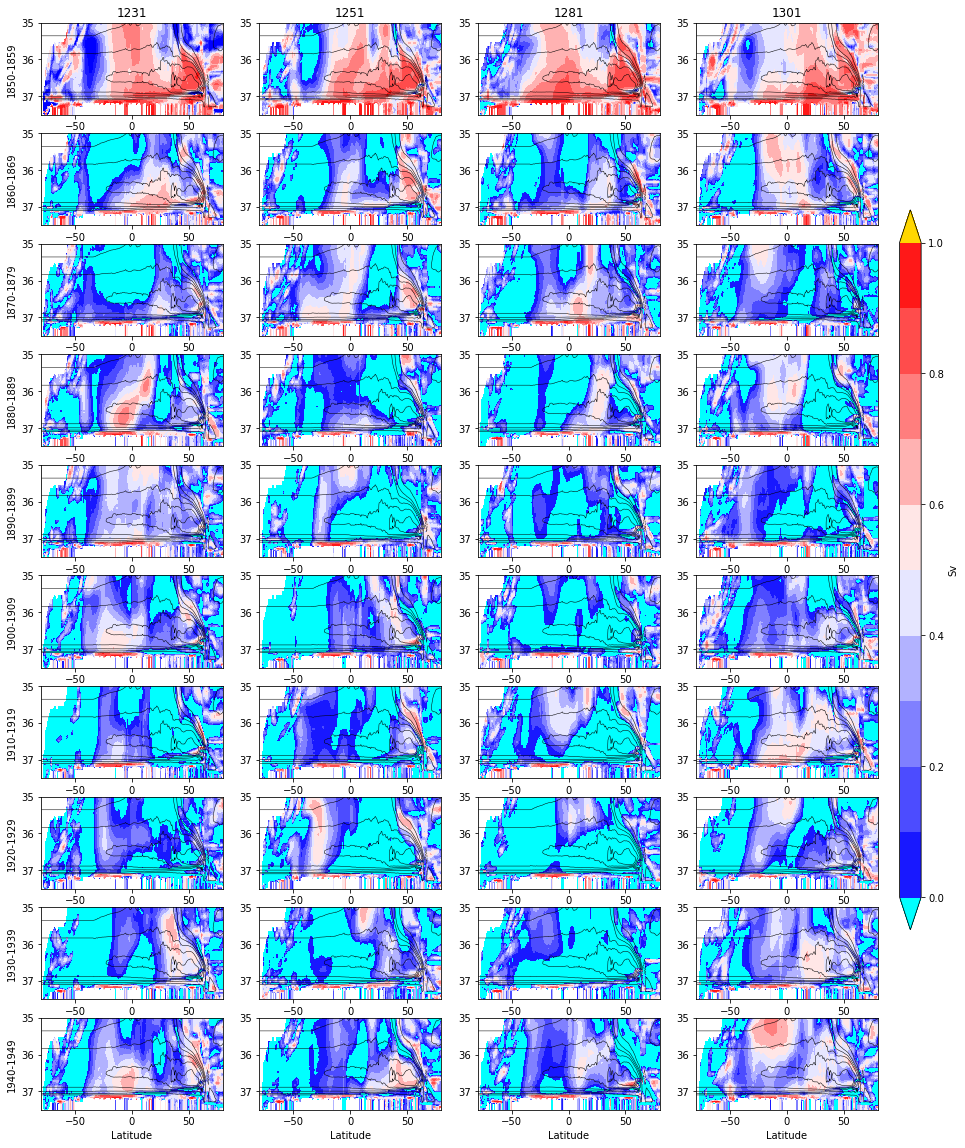

In [32]:
%%time
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,11,1)*0.1
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    #macro_mean = dsmacro1.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    std_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    std_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    std_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    std_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    ppp_1231 = 1 - ((std_1231**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    ppp_1251 = 1 - ((std_1251**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    ppp_1281 = 1 - ((std_1281**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    ppp_1301 = 1 - ((std_1301**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(ppp_1231.lat_aux_grid, ppp_1231.moc_s, ppp_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-80, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(ppp_1251.lat_aux_grid, ppp_1251.moc_s, ppp_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-80, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(ppp_1281.lat_aux_grid, ppp_1281.moc_s, ppp_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-80, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(ppp_1301.lat_aux_grid, ppp_1301.moc_s, ppp_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-80, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 15.3 s, sys: 801 ms, total: 16.1 s
Wall time: 1min 21s


<timed exec>:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


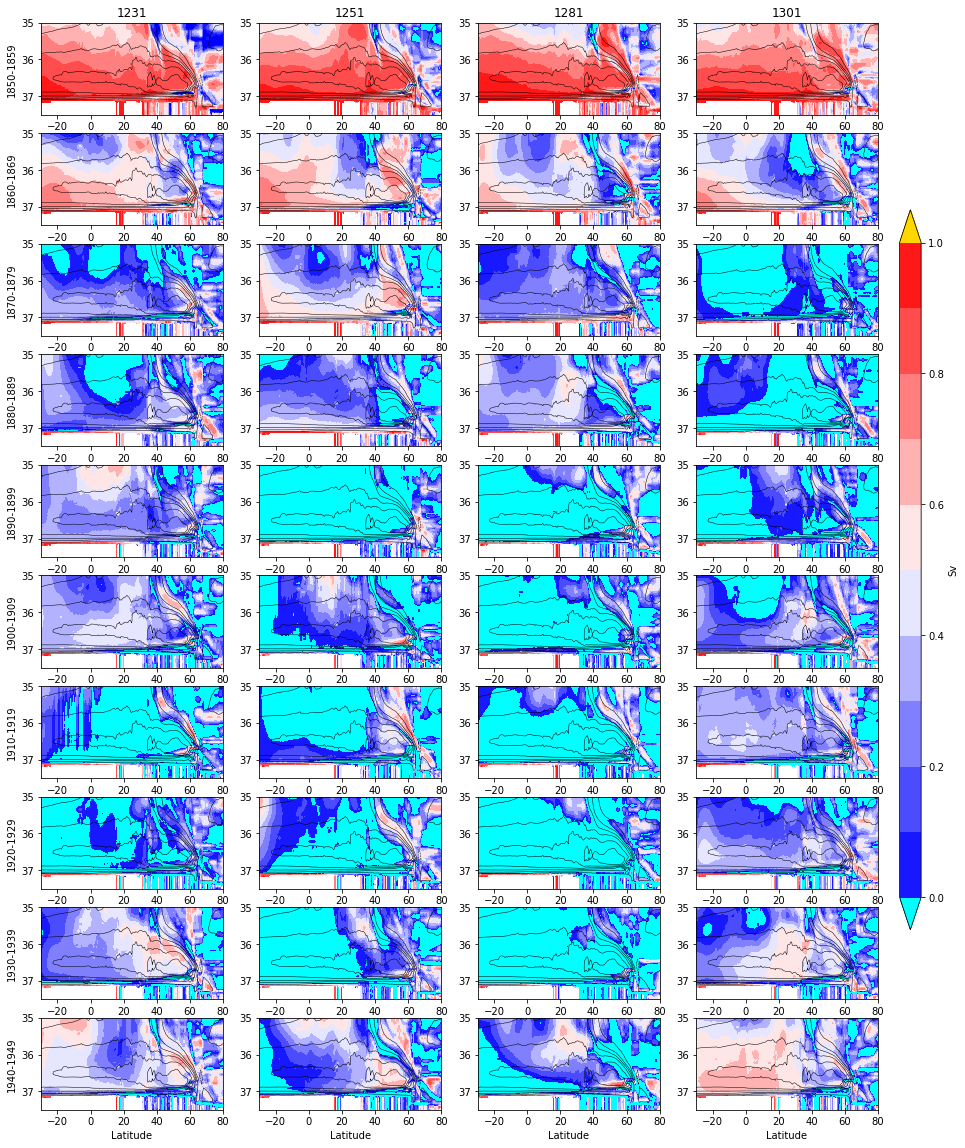

In [33]:
%%time
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,11,1)*0.1
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    #macro_mean = dsmacro1.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    std_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    std_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    std_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    std_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    ppp_1231 = 1 - ((std_1231**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    ppp_1251 = 1 - ((std_1251**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    ppp_1281 = 1 - ((std_1281**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    ppp_1301 = 1 - ((std_1301**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(ppp_1231.lat_aux_grid, ppp_1231.moc_s, ppp_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-30, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(ppp_1251.lat_aux_grid, ppp_1251.moc_s, ppp_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-30, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(ppp_1281.lat_aux_grid, ppp_1281.moc_s, ppp_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-30, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(ppp_1301.lat_aux_grid, ppp_1301.moc_s, ppp_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-30, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')